In [1]:
# Imports
import datetime
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import theano
import theano.tensor as tt
import pymc3 as pm

#import logging
#log = logging.getLogger(__name__)

try:
    import covid19_inference as cov19
    print("Option 1")
except ModuleNotFoundError:
    sys.path.append("../")
    import covid19_inference as cov19
    print("Option 2")

Option 2


In [27]:
cases_df = pd.read_csv("CaseData.csv")
cases_df.head()

,County Name,Date,Cases,DailyNew
0,Anderson,2020-03-04,0.0,x
1,Andrews,2020-03-04,0.0,x
2,Angelina,2020-03-04,0.0,x
3,Aransas,2020-03-04,0.0,x
4,Archer,2020-03-04,0.0,x


In [8]:
pop_df = pd.read_csv('PopEstimates.csv')
pop_df.head()

,year,FIPS,area_name,total,total_male,total_female,nh_white_total,nh_white_male,nh_white_female,nh_black_total,...,nh_black_female,hispanic_total,hispanic_male,hispanic_female,nh_asian_total,nh_asian_male,nh_asian_female,nh_other_total,nh_other_male,nh_other_female
0,2010,0,State of Texas,25145561,12472280,12673281,11397345,5632646,5764699,2886825,...,1494415,9460921,4763753,4697168,948426,460855,487571,452044,222616,229428
1,2011,0,State of Texas,25567291,12684177,12883114,11473189,5672925,5800264,2948232,...,1525637,9681249,4873297,4807952,995813,484336,511477,468808,231024,237784
2,2012,0,State of Texas,25996722,12899473,13097249,11548679,5712731,5835948,3011317,...,1557750,9905223,4984546,4920677,1045280,508836,536444,486223,239793,246430
3,2013,0,State of Texas,26433242,13118331,13314911,11624174,5752529,5871645,3075723,...,1590409,10132148,5097205,5034943,1096888,534427,562461,504309,248856,255453
4,2014,0,State of Texas,26876429,13340220,13536209,11699326,5791913,5907413,3141271,...,1623699,10361956,5211270,5150686,1150724,561173,589551,523152,258292,264860


In [30]:
# Get list of top 10 most populated counties (really getting 11 total, since includes state total)
top_ten_pop = pop_df[pop_df['year'] == 2020].nlargest(11, ['total'])['area_name'].values.tolist()
top_ten_pop.remove('State of Texas')
top_ten_pop_no_county = [item.split(" County")[0] for item in top_ten_pop]
print(top_ten_pop)

['Harris County', 'Dallas County', 'Tarrant County', 'Bexar County', 'Travis County', 'Collin County', 'Denton County', 'El Paso County', 'Hidalgo County', 'Fort Bend County']


In [65]:
def get_county_data(county_name):
    '''
    Given a county name, returns a tuple (daily_new_cases, pop).
    '''
    if county_name == "Texas":
        county_name = "Total"
    else:
        pass
    
    county_df = cases_df[cases_df['County Name'] == county_name]
    county_df = county_df.set_index("Date")
    county_df = county_df[["Cases"]]
    county_df.index = pd.to_datetime(county_df.index)
    
    # Correct the time index for gaps
    dmin = min(county_df.index)
    dmax = max(county_df.index)
    idx = pd.date_range(dmin, dmax)
    county_df = county_df.reindex(idx)
    county_df = county_df.sort_index()
    
    # Get daily new cases
    county_new_cases = county_df.diff()
    county_new_cases = county_new_cases.dropna()
    
    # Now get the population
    if county_name != "Total":  
        pop = pop_df[(pop_df['year'] == 2020)&(pop_df['area_name'] == county_name+" County")]['total'].values[0]
    else:
        pop = pop_df[(pop_df['year'] == 2020)&(pop_df['area_name'] == "State of Texas")]['total'].values[0]
    
    return county_new_cases, pop, county_df

In [99]:
hidalgo, hpop, hdf = get_county_data("Hidalgo")

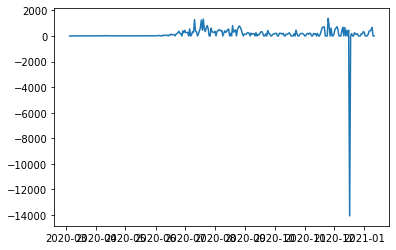

In [100]:
plt.plot(hidalgo.index, hidalgo["Cases"])

In [66]:
def build_and_calc_map(county_name):
    '''
    Runs a model given a county name.
    '''
    # Get data
    new_cases_obs, county_pop, county_df = get_county_data(county_name)
    
    # Setup params
    diff_data_sim = 16
    num_days_forecast = 10
    pr_delay = 10
    pr_len_scale = 7.0
    #pr_len_scale = 7.0 # Length scale for the GP

    # Stores the model parameters in a dict
    params_model = dict(
        new_cases_obs=new_cases_obs,
        data_begin=dmin,
        fcast_len=num_days_forecast,
        diff_data_sim=diff_data_sim,
        N_population=county_pop,
    )

    # Put model together
    with cov19.model.Cov19Model(**params_model) as this_model:

        # Adds the recovery rate mu to the model as a random variable
        mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

        # Create the array of the time dependent infection rate lambda
        #pr_len_scale = pm.Uniform('pr_len_scale', 5.0, 10.0)
        pr_amplitude = pm.Uniform('pr_amplitude', 0.1, 0.7) 
        lambda_t_log = cov19.model.lambda_t_gp(
                            mu,
                            pr_len_scale,
                            pr_amplitude,
                            #model=None,
                            name_lambda_t="lambda_t",
        )

        # This builds a decorrelated prior for I_begin for faster inference.
        prior_I = cov19.model.uncorrelated_prior_I(
            lambda_t_log=lambda_t_log, mu=mu, pr_median_delay=pr_delay
        )

        # Use lambda_t_log and mu as parameters for the SIR model.
        # The SIR model generates the inferred new daily cases.
        new_cases = cov19.model.SIR(lambda_t_log=lambda_t_log, mu=mu, pr_I_begin=prior_I)

        # Delay the cases by a lognormal reporting delay and add them as a trace variable
        new_cases = cov19.model.delay_cases(
            cases=new_cases,
            name_cases="delayed_cases",
            pr_mean_of_median=pr_delay,
            pr_median_of_width=0.3,
        )

        # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
        # Also adds the "new_cases" variable to the trace that has all model features.
        new_cases = cov19.model.week_modulation(cases=new_cases, name_cases="new_cases")

        # Define the likelihood, uses the new_cases_obs set as model parameter
        cov19.model.student_t_likelihood(cases=new_cases)
        
        # Now compute map
        map_est = pm.find_MAP()
        
        return (new_cases_obs, county_pop, county_df, map_est)

In [67]:
results = {}
for county in top_ten_pop_no_county:
    results[county] = build_and_calc_map(county)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


ValueError: array must not contain infs or NaNs
Apply node that caused the error: Solve{A_structure='upper_triangular', lower=False, overwrite_A=False, overwrite_b=False}(InplaceDimShuffle{1,0}.0, Elemwise{Composite{((i0 * i1) - i2)}}[(0, 0)].0)
Toposort index: 206
Inputs types: [TensorType(float64, matrix), TensorType(float64, matrix)]
Inputs shapes: [(334, 334), (334, 334)]
Inputs strides: [(2672, 8), (2672, 8)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[InplaceDimShuffle{1,0}(Solve{A_structure='upper_triangular', lower=False, overwrite_A=False, overwrite_b=False}.0)]]

Backtrace when the node is created(use Theano flag traceback__limit=N to make it longer):
  File "C:\Users\Jonathan\anaconda3\lib\site-packages\theano\gradient.py", line 1393, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "C:\Users\Jonathan\anaconda3\lib\site-packages\theano\gradient.py", line 1061, in access_term_cache
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "C:\Users\Jonathan\anaconda3\lib\site-packages\theano\gradient.py", line 1061, in <listcomp>
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "C:\Users\Jonathan\anaconda3\lib\site-packages\theano\gradient.py", line 1393, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "C:\Users\Jonathan\anaconda3\lib\site-packages\theano\gradient.py", line 1061, in access_term_cache
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "C:\Users\Jonathan\anaconda3\lib\site-packages\theano\gradient.py", line 1061, in <listcomp>
    output_grads = [access_grad_cache(var) for var in node.outputs]
  File "C:\Users\Jonathan\anaconda3\lib\site-packages\theano\gradient.py", line 1393, in access_grad_cache
    term = access_term_cache(node)[idx]
  File "C:\Users\Jonathan\anaconda3\lib\site-packages\theano\gradient.py", line 1220, in access_term_cache
    input_grads = node.op.L_op(inputs, node.outputs, new_output_grads)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [68]:
results["Texas"] = build_and_calc_map("Texas")

INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


In [70]:
tx_df, tx_pop, tx_full_df, tx_res = results["Texas"]

In [77]:
min_date = min(tx_df.index)
max_date = max(tx_df.index)
print(min_date)
print(max_date)

2020-03-05 00:00:00
2021-01-11 00:00:00


In [80]:
data_idx = pd.date_range(min_date, max_date)

In [81]:
diff_data_sim = 16
num_days_forecast = 10

In [82]:
len(data_idx) + diff_data_sim + num_days_forecast

339

In [85]:
len(data_idx) + diff_data_sim + num_days_forecast

334

In [83]:
tx_res["r_t"].shape

(334,)

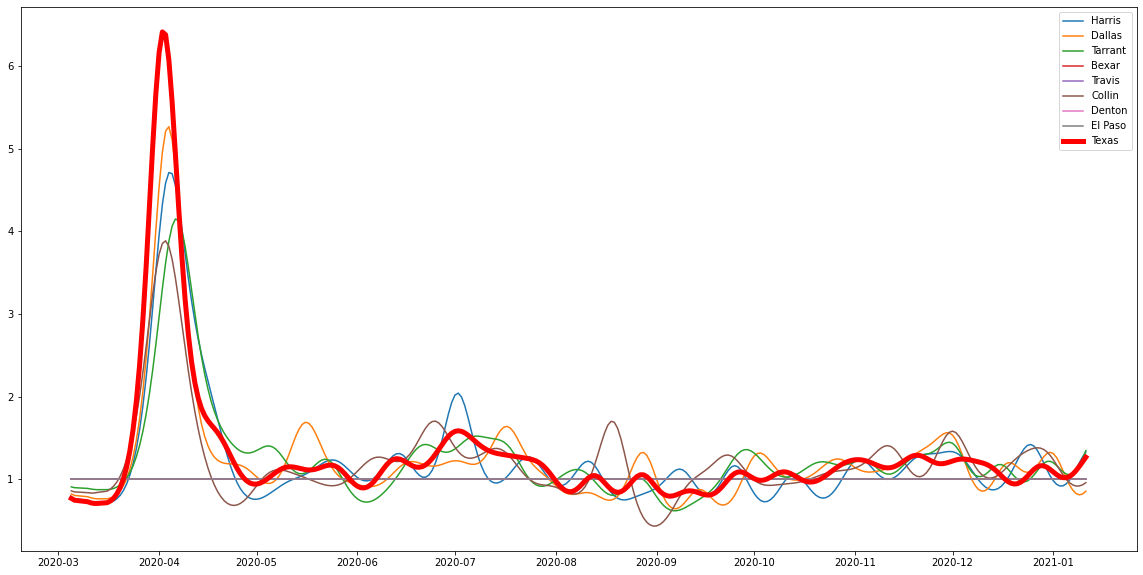

In [96]:
plt.figure(figsize=(20,10))
diff_data_sim = 16
num_days_forecast = 10
for county in top_ten_pop_no_county:
    if county == "Hidalgo" or county == "Fort Bend":
        pass
    else:
        county_df, county_pop, county_full_df, county_res = results[county]
        plt.plot(county_df.index, county_res["r_t"][diff_data_sim:-num_days_forecast], label=county)

county_df, county_pop, county_full_df, county_res = results["Texas"]
plt.plot(county_df.index, county_res["r_t"][diff_data_sim:-num_days_forecast], label="Texas", color="red", linewidth=5.0)
plt.legend()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

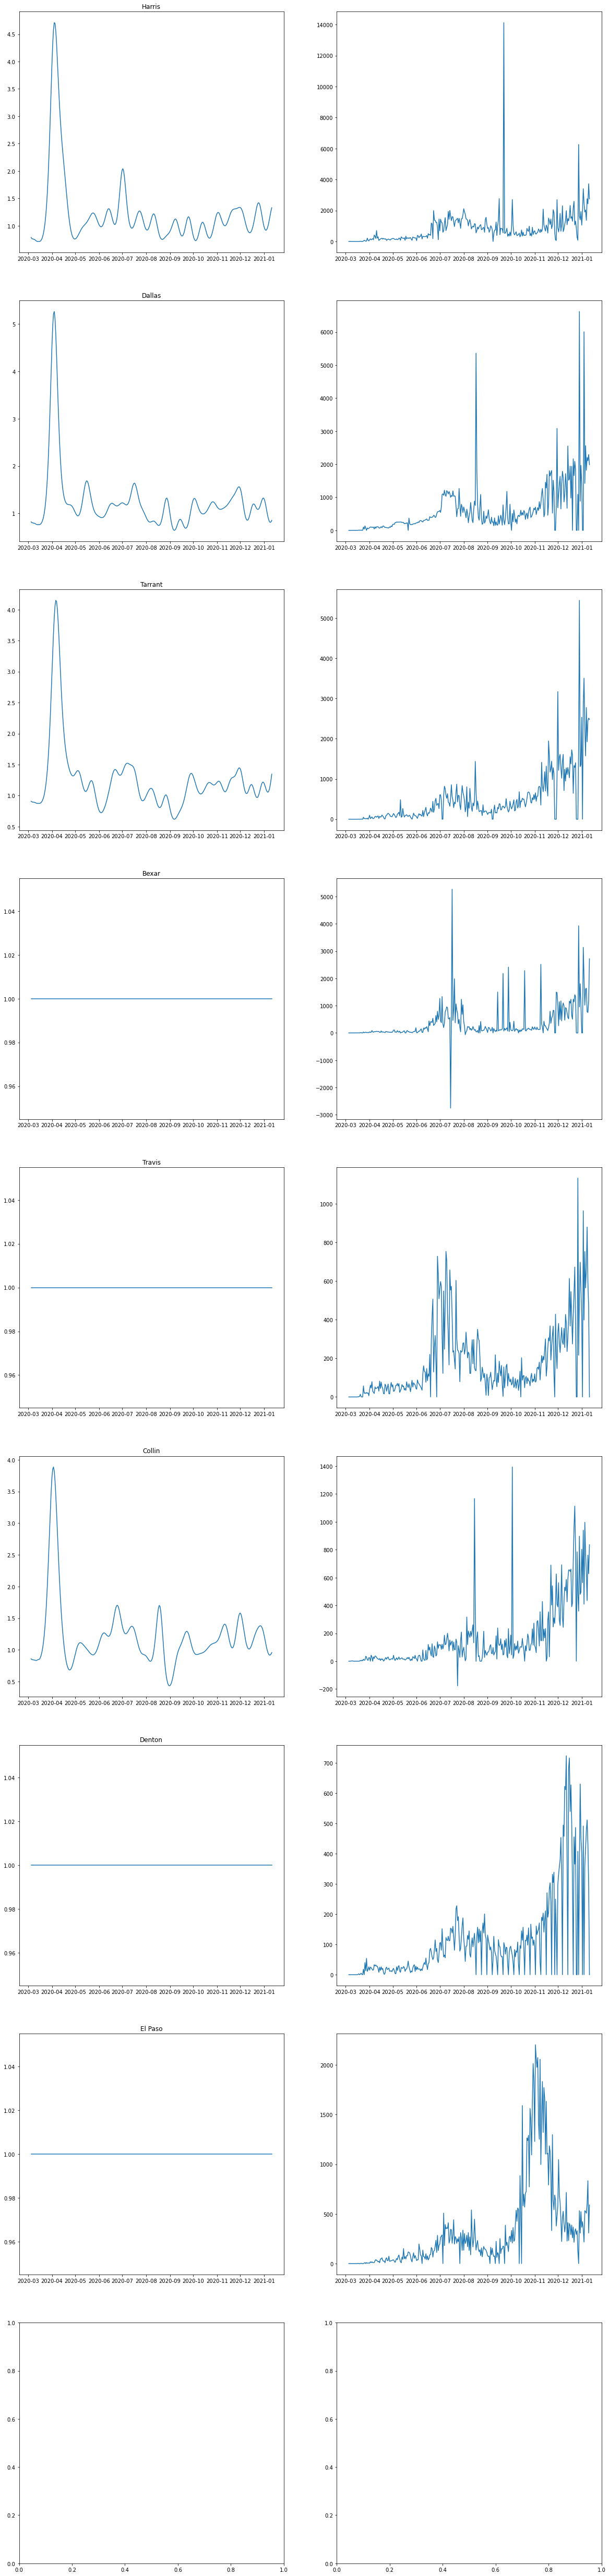

In [98]:
fig, axs = plt.subplots(9, 2, figsize=(20,10*9))
diff_data_sim = 16
num_days_forecast = 10
for j, county in enumerate(top_ten_pop_no_county):
    if county == "Hidalgo" or county == "Fort Bend":
        pass
    else:
        county_df, county_pop, county_full_df, county_res = results[county]
        axs[j,0].plot(county_df.index, county_res["r_t"][diff_data_sim:-num_days_forecast], label=county)
        axs[j,0].set_title(county)
        
        axs[j,1].plot(county_df.index, county_df["Cases"].values)

county_df, county_pop, county_full_df, county_res = results["Texas"]
axs[8].plot(county_df.index, county_res["r_t"][diff_data_sim:-num_days_forecast], label="Texas")
fig.show()

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
kerns = tfp.math.psd_kernels
tfk = tfp.math.psd_kernels

In [274]:
pr_amp = tx_res["pr_amplitude"]
pr_len_scale = 7.0

X = np.arange(0, tx_res["r_t"].shape[0])[:,None]

fdays = 30
X_new = np.arange(tx_res["r_t"].shape[0], tx_res["r_t"].shape[0] + fdays)[:,None]

# Setup the tensorflow gprm
var = tf.constant(pr_amp, dtype = tf.float64)
length = tf.constant(pr_len_scale, dtype = tf.float64)
kern = kerns.ExponentiatedQuadratic(length_scale=length, amplitude=var)
gprm = tfd.GaussianProcessRegressionModel(kern, index_points=X_new.astype(np.float64), 
                                         observation_index_points=X.astype(np.float64),
                                         observations=tx_res["log_r_t"].astype(np.float64),
                                         observation_noise_variance=0.0,
                                         mean_fn=None,
                                         jitter=1e-06)
# Now compute future samples
fsamps = np.exp(gprm.sample(10000).numpy())

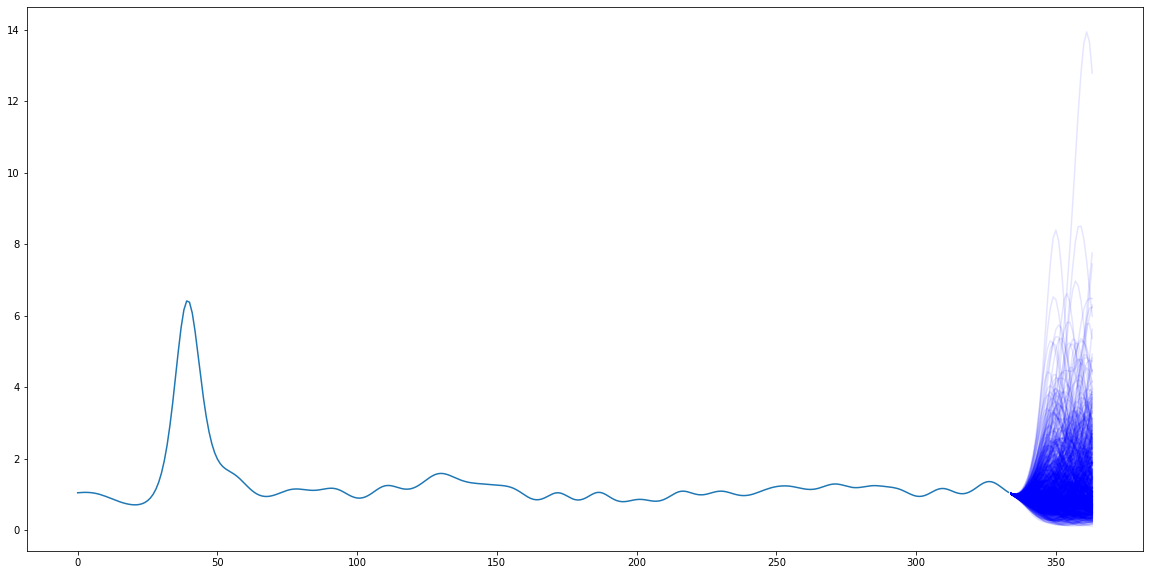

In [262]:
plt.figure(figsize=(20,10))
plt.plot(X[:,0], tx_res["r_t"])
for j in range(1000):
    plt.plot(X_new[:,0], fsamps[j,:], alpha=0.1, color="blue")
plt.show()

In [263]:
def compute_bands(vals, levels=[1.0, 5.5, 12.5, 25, 75, 87.5, 94.5, 99.0]):
    '''
    Given an array with shape (x, y, z) where x is the dimension for samples, y is the 
    dimension for time, and z the dimension variable, computes the corresponding percentile bands for credible intervals.
    '''
    def scoreatpercentile(vals, p):
        return np.percentile(vals, p, axis=0)
    perc = {p:scoreatpercentile(vals,p) for p in levels}
    median = np.median(vals, axis=0)
    perc["median"] = median
    return perc

In [275]:
bands = compute_bands(fsamps)

In [269]:
bands[1.0].shape

(30,)

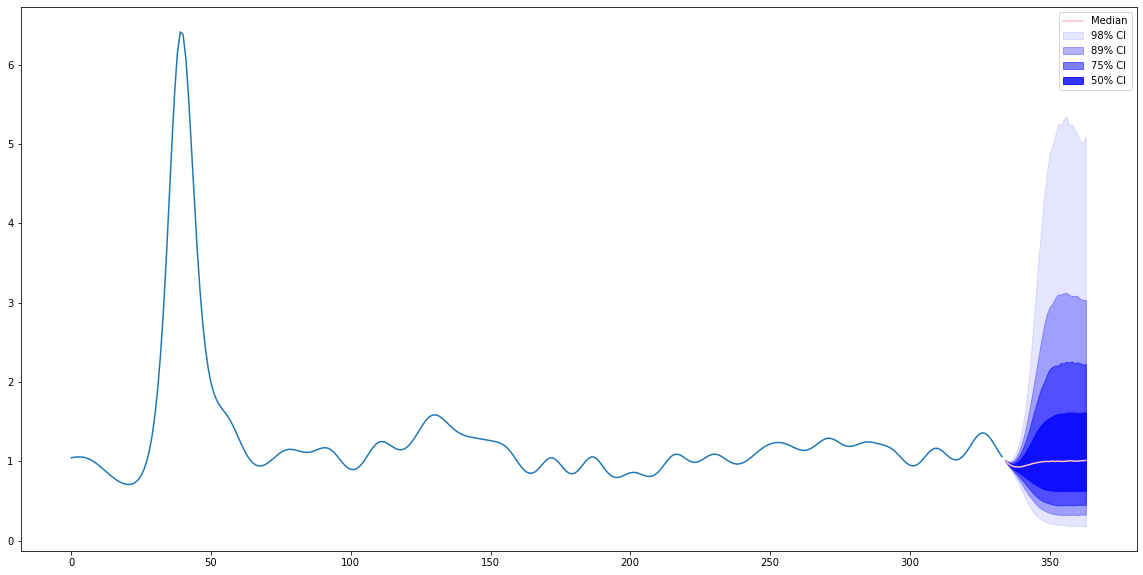

In [276]:
plt.figure(figsize=(20,10))
plt.plot(X[:,0], tx_res["r_t"])
plt.fill_between(X_new[:,0], bands[1.0], bands[99.0], alpha=0.1, color="b", label="98% CI")
plt.fill_between(X_new[:,0], bands[5.5], bands[94.5], alpha=0.3, color="b", label="89% CI")
plt.fill_between(X_new[:,0], bands[12.5], bands[87.5], alpha=0.5, color="b", label="75% CI")
plt.fill_between(X_new[:,0], bands[25], bands[75], alpha=0.8, color="b", label="50% CI")
plt.plot(X_new[:,0], bands["median"], alpha=1.0, color="pink", label="Median")
plt.legend()
plt.show()

# Lets try TX

In [279]:
# Get data
county_name = "Texas"
new_cases_obs, county_pop, county_df = get_county_data(county_name)
# Now try skipping first 20 days
new_cases_obs = new_cases_obs[20:]
    
# Setup params
diff_data_sim = 16
num_days_forecast = 10
pr_delay = 10
pr_len_scale = 7.0
#pr_len_scale = 7.0 # Length scale for the GP

# Stores the model parameters in a dict
params_model = dict(
    new_cases_obs=new_cases_obs,
    data_begin=dmin,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=county_pop,
    )

    # Put model together
with cov19.model.Cov19Model(**params_model) as this_model:

    # Adds the recovery rate mu to the model as a random variable
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # Create the array of the time dependent infection rate lambda
    #pr_len_scale = pm.Uniform('pr_len_scale', 5.0, 10.0)
    pr_amplitude = pm.Uniform('pr_amplitude', 0.1, 0.7) 
    lambda_t_log = cov19.model.lambda_t_gp(
                            mu,
                            pr_len_scale,
                            pr_amplitude,
                            #model=None,
                            name_lambda_t="lambda_t",
        )

    # This builds a decorrelated prior for I_begin for faster inference.
    prior_I = cov19.model.uncorrelated_prior_I(
            lambda_t_log=lambda_t_log, mu=mu, pr_median_delay=pr_delay
        )

    # Use lambda_t_log and mu as parameters for the SIR model.
    # The SIR model generates the inferred new daily cases.
    new_cases = cov19.model.SIR(lambda_t_log=lambda_t_log, mu=mu, pr_I_begin=prior_I)

    # Delay the cases by a lognormal reporting delay and add them as a trace variable
    new_cases = cov19.model.delay_cases(
            cases=new_cases,
            name_cases="delayed_cases",
            pr_mean_of_median=pr_delay,
            pr_median_of_width=0.3,
        )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(cases=new_cases, name_cases="new_cases")

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(cases=new_cases)
        
    # Now compute map
    map_est = pm.find_MAP()

INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation


In [280]:
tx_df = new_cases_obs
tx_pop = county_pop
tx_full_df = county_df
tx_res = map_est

In [284]:
pr_amp = tx_res["pr_amplitude"]
pr_len_scale = 7.0

X = np.arange(0, tx_res["r_t"].shape[0])[:,None]

fdays = 100
X_new = np.arange(tx_res["r_t"].shape[0], tx_res["r_t"].shape[0] + fdays)[:,None]

# Setup the tensorflow gprm
var = tf.constant(pr_amp, dtype = tf.float64)
length = tf.constant(pr_len_scale, dtype = tf.float64)
kern = kerns.ExponentiatedQuadratic(length_scale=length, amplitude=var)
gprm = tfd.GaussianProcessRegressionModel(kern, index_points=X_new.astype(np.float64), 
                                         observation_index_points=X.astype(np.float64),
                                         observations=tx_res["log_r_t"].astype(np.float64),
                                         observation_noise_variance=0.0,
                                         mean_fn=None,
                                         jitter=1e-06)
# Now compute future samples
fsamps = np.exp(gprm.sample(10000).numpy())

bands = compute_bands(fsamps)

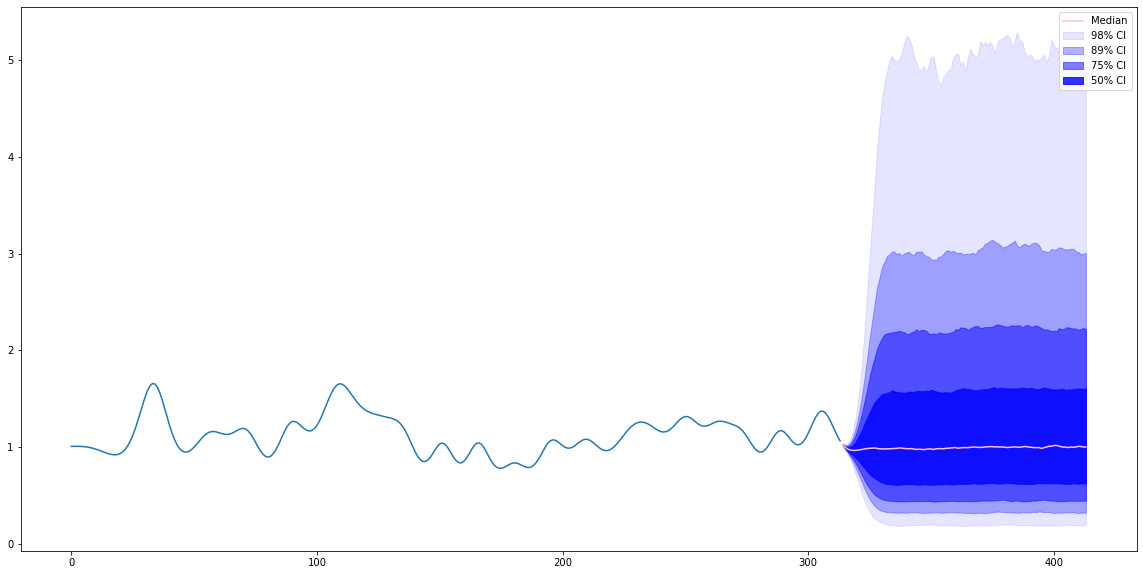

In [285]:
plt.figure(figsize=(20,10))
plt.plot(X[:,0], tx_res["r_t"])
plt.fill_between(X_new[:,0], bands[1.0], bands[99.0], alpha=0.1, color="b", label="98% CI")
plt.fill_between(X_new[:,0], bands[5.5], bands[94.5], alpha=0.3, color="b", label="89% CI")
plt.fill_between(X_new[:,0], bands[12.5], bands[87.5], alpha=0.5, color="b", label="75% CI")
plt.fill_between(X_new[:,0], bands[25], bands[75], alpha=0.8, color="b", label="50% CI")
plt.plot(X_new[:,0], bands["median"], alpha=1.0, color="pink", label="Median")
plt.legend()
plt.show()

# Now let's actually sample TX

In [287]:
# Get data
county_name = "Texas"
new_cases_obs, county_pop, county_df = get_county_data(county_name)
# Now try skipping first 20 days
new_cases_obs = new_cases_obs[20:]
    
# Setup params
diff_data_sim = 16
num_days_forecast = 10
pr_delay = 10
pr_len_scale = 7.0
#pr_len_scale = 7.0 # Length scale for the GP

# Stores the model parameters in a dict
params_model = dict(
    new_cases_obs=new_cases_obs,
    data_begin=dmin,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=county_pop,
    )

    # Put model together
with cov19.model.Cov19Model(**params_model) as this_model:

    # Adds the recovery rate mu to the model as a random variable
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # Create the array of the time dependent infection rate lambda
    #pr_len_scale = pm.Uniform('pr_len_scale', 5.0, 10.0)
    pr_amplitude = pm.Uniform('pr_amplitude', 0.1, 0.7) 
    lambda_t_log = cov19.model.lambda_t_gp(
                            mu,
                            pr_len_scale,
                            pr_amplitude,
                            #model=None,
                            name_lambda_t="lambda_t",
        )

    # This builds a decorrelated prior for I_begin for faster inference.
    prior_I = cov19.model.uncorrelated_prior_I(
            lambda_t_log=lambda_t_log, mu=mu, pr_median_delay=pr_delay
        )

    # Use lambda_t_log and mu as parameters for the SIR model.
    # The SIR model generates the inferred new daily cases.
    new_cases = cov19.model.SIR(lambda_t_log=lambda_t_log, mu=mu, pr_I_begin=prior_I)

    # Delay the cases by a lognormal reporting delay and add them as a trace variable
    new_cases = cov19.model.delay_cases(
            cases=new_cases,
            name_cases="delayed_cases",
            pr_mean_of_median=pr_delay,
            pr_median_of_width=0.3,
        )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(cases=new_cases, name_cases="new_cases")

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(cases=new_cases)
        
    # Now compute map
    #map_est = pm.find_MAP()
    
    # Sample
    trace = pm.sample(draws=2000, tune=2000, cores=1)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with gp
INFO     [covid19_inference.model.compartmental_models] Uncorrelated prior_I
INFO     [covid19_inference.model.compartmental_models] SIR
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation
C:\Users\Jonathan\anaconda3\lib\site-packages\pymc3\sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
INFO     [pymc3] Sequential sampling (2 chains in 1 job)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_hc_L2_log_r

Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 35437 seconds.
INFO     [pymc3] Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 35437 seconds.
There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc3] There were 58 divergences after tuning. Increase `target_accept` or reparameterize.
There were 291 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc3] There were 291 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
INFO     [pymc3] The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR    [pymc3] The estimated number of effective samples is smaller than 200 fo

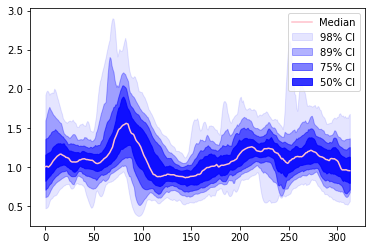

In [292]:
nsamps, nobs = trace["r_t"].shape
bands = compute_bands(trace["r_t"])
#for j in range(100):
#    plt.figure(figsize=(20,10))
#plt.plot(X[:,0], tx_res["r_t"])
plt.fill_between([i for i in range(nobs)], bands[1.0], bands[99.0], alpha=0.1, color="b", label="98% CI")
plt.fill_between([i for i in range(nobs)], bands[5.5], bands[94.5], alpha=0.3, color="b", label="89% CI")
plt.fill_between([i for i in range(nobs)], bands[12.5], bands[87.5], alpha=0.5, color="b", label="75% CI")
plt.fill_between([i for i in range(nobs)], bands[25], bands[75], alpha=0.8, color="b", label="50% CI")
plt.plot([i for i in range(nobs)], bands["median"], alpha=1.0, color="pink", label="Median")
plt.legend()
plt.show()
    #plt.plot(trace["r_t"][j,:], alpha=0.1)